In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import re
import os

from sklearn.model_selection import train_test_split

import gensim

import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

unable to import 'smart_open.gcs', disabling that module
Using TensorFlow backend.


## Section 3

### 3.1 Data Acquisition 

In [2]:
dataset_path = r"C:\Users\gbao\Documents\Final project\training.1600000.processed.noemoticon.csv"
df = pd.read_csv(dataset_path, encoding ="ISO-8859-1" , names=["target", "ids", "date", "flag", "user", "text"])
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### 3.2 Data Cleaning

#### Label Target Variable 

In [3]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]
df.target = df.target.apply(lambda x: decode_sentiment(x))
df.head()

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


####  Exploratory Data Analysis

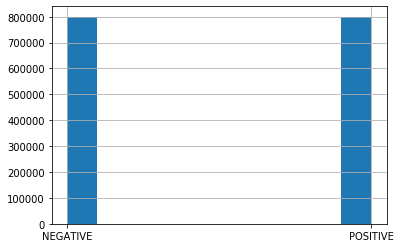

In [4]:
df.target.hist()

####  Text Cleaning

In [5]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [6]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

df.text = df.text.apply(lambda x: preprocess(x))

#### Split Train and Test Dataset 

In [7]:
df_train, df_test = train_test_split(df, test_size=1-0.75, random_state=42)

#### Word2Vec 

In [8]:
documents = [_text.split() for _text in df_train.text] 
w2v_model = gensim.models.word2vec.Word2Vec(size=300, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)
w2v_model.build_vocab(documents)
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print(f"Vocab size is {vocab_size}")
w2v_model.train(documents, total_examples=len(documents), epochs=32)

Vocab size is 29208


(246348952, 276847840)

#### Tokenize Text 

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 278491


In [10]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=300)